# Multi-track hit classification with LSTMs

Let's see how well an LSTM model can disambiguate hits into multiple track assignments.

We should do this in 2D, at least for now. Then the data structure is basically an image with channels for each track plus a channel for unassigned hits.

In [1]:
# System imports
from __future__ import print_function

# External imports
import numpy as np
from keras import models
from keras import layers
from matplotlib import pyplot as plt

# Local imports
from data import (generate_straight_track, generate_straight_tracks,
                  generate_uniform_noise, generate_track_bkg)
from drawing import draw_2d_event, draw_2d_input_and_pred

%matplotlib notebook

Using TensorFlow backend.


## Utilities

In [2]:
def draw_train_history(history, figsize=(9,4)):
    train_accs = [np.array(history.history[k]) for k in history.history.keys()
                  if not k.startswith('val') and k.endswith('acc')]
    val_accs = [np.array(history.history[k]) for k in history.history.keys()
                if k.startswith('val') and k.endswith('acc')]
    avg_train_acc = sum(train_accs) / len(train_accs)
    avg_val_acc = sum(val_accs) / len(val_accs)
    # Plot the loss
    fig = plt.figure(figsize=figsize)
    plt.subplot(121)
    epochs = history.epoch
    plt.plot(epochs, history.history['loss'], label='Training set')
    plt.plot(epochs, history.history['val_loss'], label='Validation set')
    plt.title('Loss')
    plt.legend(loc=0)
    plt.xlabel('Training epoch')
    plt.ylabel('Loss')
    # Plot the accuracy
    plt.subplot(122)
    plt.plot(epochs, avg_train_acc, label='Training set average')
    plt.plot(epochs, avg_val_acc, label='Validation set average')
    plt.ylim((0,1))
    plt.title('Accuracy')
    plt.xlabel('Training epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc=0)
    plt.tight_layout()
    return fig

def draw_outputs(event, preds, figsize=(10,7), nrows=2, ncols=3):
    fig = plt.figure(figsize=figsize)
    # Draw the input
    plt.subplot(nrows, ncols, 1)
    draw_2d_event(event, title='Model input')
    # Draw each of the outputs
    for itrk in range(len(preds)):
        plt.subplot(nrows, ncols, itrk+2)
        draw_2d_event(preds[itrk], title='Model prediction %i' % itrk)
    return fig

def history_report(history):
    """Report on the final loss and accuracies"""
    keys = sorted(history.history.keys())
    print('Final losses')
    print('  train: %g' % history.history['loss'][-1])
    print('  valid: %g' % history.history['val_loss'][-1])
    print('Final accuracies')
    for key in keys:
        if key.endswith('acc'):
            print('  %s: %g' % (key, history.history[key][-1]))

## Data generation

Let's first develop the data by deciding the format and writing the code to generate it.

In [3]:
def generate_data(num_event, det_shape, num_sig_tracks, seed_size, noise_prob):
    """Generate some data"""
    sig_tracks = [generate_straight_tracks(num_event, det_shape)
                  for _ in range(num_sig_tracks)]
    noise = generate_uniform_noise(num_event, det_shape, prob=noise_prob, 
                                   skip_layers=seed_size)
    return sig_tracks, noise

In [4]:
# Detector config
det_width = 50
det_depth = 50
det_shape = (det_depth, det_width)
seed_size = 5

In [5]:
# Data config
num_event = 204800
num_tracks = 5
noise_prob = 0
sig_tracks, noise = generate_data(num_event, det_shape, num_tracks, 0, noise_prob)

In [6]:
# Construct full non-binary event images with summed charge
events = sum(sig_tracks + [noise])
#events[events > 1] = 1

# Prepare model inputs and target
train_input = [t.copy() for t in sig_tracks] + [events]
for i in range(num_tracks):
    train_input[i][:,seed_size:,:] = 0
train_target = sig_tracks

<IPython.core.display.Javascript object>


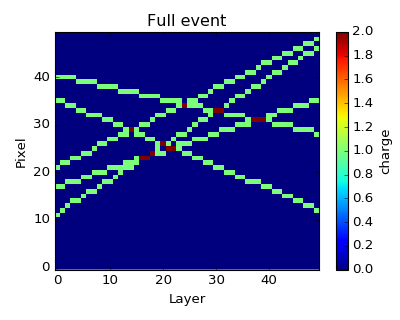

<IPython.core.display.Javascript object>


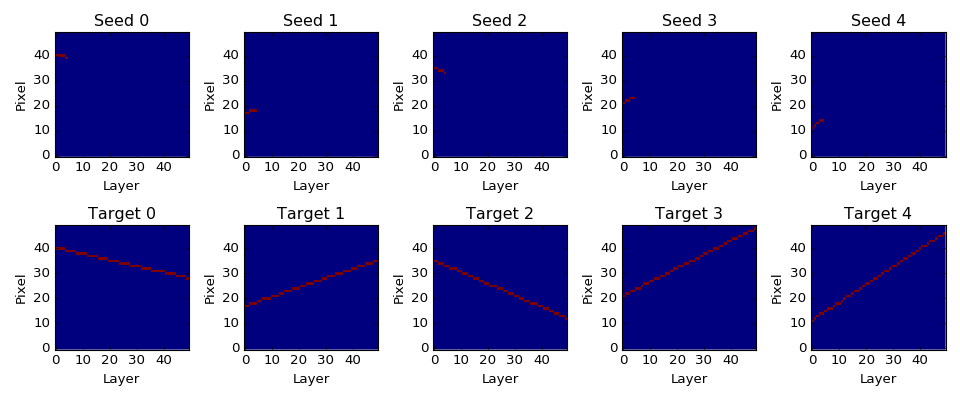

In [7]:
# Draw a typical event and the inputs and outputs
ievt = 0
# Draw the raw event first
fig00 = plt.figure(figsize=(5,4))
draw_2d_event(events[ievt], title='Full event')
plt.colorbar().set_label('charge')
# Draw the seeds and targets
fig01 = plt.figure(figsize=(12,5))
for itrk in range(num_tracks):
    # Draw the input seed
    plt.subplot(2, num_tracks, itrk + 1)
    draw_2d_event(train_input[itrk][ievt], title='Seed %i' % itrk)
    # Draw the target
    plt.subplot(2, num_tracks, num_tracks + itrk + 1)
    draw_2d_event(train_target[itrk][ievt], title='Target %i' % itrk)
plt.tight_layout()

## Basic multi-channel LSTM

In [ ]:
def build_model_1(det_shape, num_tracks=2, hidden_dim=100):
    """
    Construct a basic multi-channel LSTM model.
    This model does a per-channel softmax over the pixels in each layer.
    """
    det_depth, det_width = det_shape
    # Separate input channels (num_tracks + a raw input channel)
    inputs = [layers.Input(shape=det_shape) for i in range(num_tracks+1)]
    merged_inputs = layers.merge(inputs, mode='concat', concat_axis=2)
    # Flatten out the channel dimension
    flat_inputs = layers.Reshape((det_depth, det_width * (num_tracks+1)))(merged_inputs)
    # Apply the LSTM
    hidden = layers.LSTM(hidden_dim, return_sequences=True)(flat_inputs)
    hidden = layers.TimeDistributed(layers.Dense(hidden_dim))(hidden)
    # Dense layer transforms to concatenated output shape
    hidden = layers.TimeDistributed(layers.Dense(det_width*num_tracks))(hidden)
    # Split output channels
    outputs = [layers.Lambda(lambda x: x[:,:,i*det_width:(i+1)*det_width])(hidden)
               for i in range(num_tracks)]
    # Apply softmax to each layer in each output channel
    outputs = [layers.TimeDistributed(layers.Activation('softmax'))(output)
               for output in outputs]
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

In [ ]:
model1 = build_model_1(det_shape, num_tracks, hidden_dim=500)
history1 = model1.fit(train_input, train_target, batch_size=128, nb_epoch=10, validation_split=0.2)
train1_pred = model1.predict(train_input)

Train on 163840 samples, validate on 40960 samples
Epoch 1/10
 97024/163840 [================>.............] - ETA: 88s - loss: 0.8694 - timedistributed_3_loss: 0.1741 - timedistributed_4_loss: 0.1726 - timedistributed_5_loss: 0.1788 - timedistributed_6_loss: 0.1720 - timedistributed_7_loss: 0.1719 - timedistributed_3_acc: 0.9300 - timedistributed_4_acc: 0.9305 - timedistributed_5_acc: 0.9280 - timedistributed_6_acc: 0.9307 - timedistributed_7_acc: 0.9305

Final losses
  train: 0.711922
  valid: 1.16358
Final accuracies
  timedistributed_3_acc: 0.944793
  timedistributed_4_acc: 0.943964
  timedistributed_5_acc: 0.943497
  timedistributed_6_acc: 0.944788
  timedistributed_7_acc: 0.944488
  val_timedistributed_3_acc: 0.921495
  val_timedistributed_4_acc: 0.92064
  val_timedistributed_5_acc: 0.91971
  val_timedistributed_6_acc: 0.922672
  val_timedistributed_7_acc: 0.923765


<IPython.core.display.Javascript object>


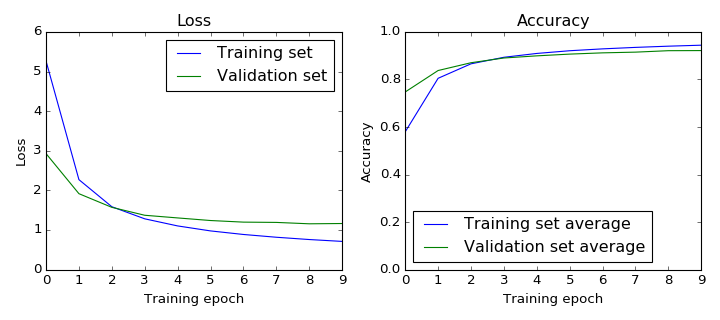

<IPython.core.display.Javascript object>


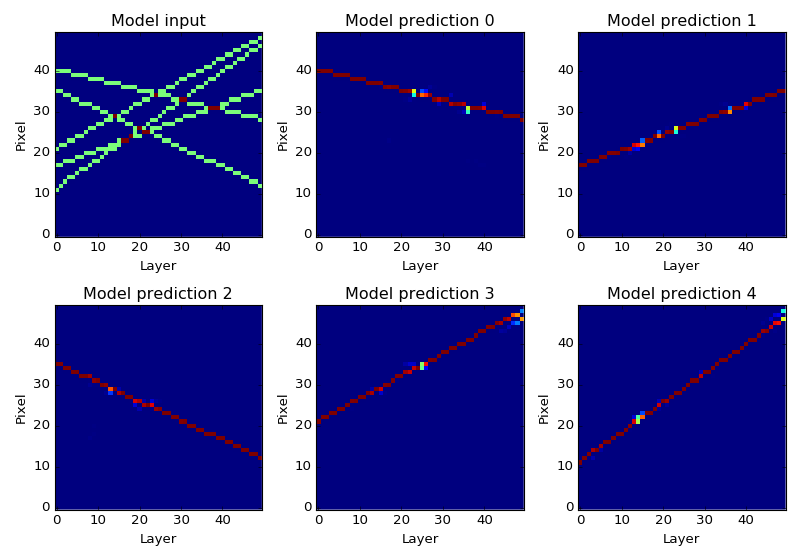

In [16]:
history_report(history1)
fig0 = draw_train_history(history1)
fig1 = draw_outputs(events[ievt], [p[ievt] for p in train1_pred])

## LSTM multi-pass model

What if I instead had a model which internally looped over the data to produce a refined prediction?

In [ ]:
def build_model_2(det_shape, num_tracks=2, hidden_dim=100, num_iterations=2):
    """
    Same as above but this model makes multiple passes
    over the data to refine the prediction.
    """
    # Separate input channels (num_tracks + a raw input channel)
    inputs = [layers.Input(shape=det_shape) for i in range(num_tracks+1)]
    iter_inputs = inputs

    # Create the layers we will reuse in the loop
    lstm_layer = layers.LSTM(hidden_dim, return_sequences=True)
    dense_layer = layers.TimeDistributed(layers.Dense(det_width*num_tracks))

    # Loop over the data to make/refine prediction
    for i in range(num_iterations):
        merged_inputs = layers.merge(iter_inputs, mode='concat', concat_axis=2)
        # Apply the LSTM
        hidden = lstm_layer(merged_inputs)
        # Dense layer transforms to concatenated output shape
        hidden = dense_layer(hidden)
        # Split output channels
        iter_outputs = [layers.Lambda(lambda x: x[:,:,i*det_width:(i+1)*det_width])(hidden)
                        for i in range(num_tracks)]
        # Apply softmax to each layer
        iter_outputs = [layers.TimeDistributed(layers.Activation('softmax'))(outs)
                        for outs in iter_outputs]
        # Build inputs for next iteration
        iter_inputs = iter_outputs + [inputs[-1]]

    # Final outputs
    outputs = iter_outputs

    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

In [ ]:
model3 = build_model_2(det_shape, num_tracks=num_tracks,
                       hidden_dim=500, num_iterations=2)
history3 = model3.fit(train_input, train_target, batch_size=128, nb_epoch=10, validation_split=0.2)
train3_pred = model3.predict(train_input)

163840/163840 [==============================] - 251s - loss: 2.2911 - timedistributed_14_loss: 0.3416 - timedistributed_15_loss: 0.3509 - timedistributed_16_loss: 0.5147 - timedistributed_17_loss: 0.5508 - timedistributed_18_loss: 0.5332 - timedistributed_14_acc: 0.8725 - timedistributed_15_acc: 0.8732 - timedistributed_16_acc: 0.7960 - timedistributed_17_acc: 0.7797 - timedistributed_18_acc: 0.7919 - val_loss: 2.0099 - val_timedistributed_14_loss: 0.2985 - val_timedistributed_15_loss: 0.3071 - val_timedistributed_16_loss: 0.4468 - val_timedistributed_17_loss: 0.4816 - val_timedistributed_18_loss: 0.4760 - val_timedistributed_14_acc: 0.8908 - val_timedistributed_15_acc: 0.8916 - val_timedistributed_16_acc: 0.8266 - val_timedistributed_17_acc: 0.8118 - val_timedistributed_18_acc: 0.8188
Epoch 4/10
163840/163840 [==============================] - 258s - loss: 1.7248 - timedistributed_14_loss: 0.2567 - timedistributed_15_loss: 0.2653 - timedistributed_16_loss: 0.3775 - timedistributed_17

Final losses
  train: 0.961007
  valid: 1.30244
Final accuracies
  timedistributed_14_acc: 0.947334
  timedistributed_15_acc: 0.950352
  timedistributed_16_acc: 0.926489
  timedistributed_17_acc: 0.91524
  timedistributed_18_acc: 0.916943
  val_timedistributed_14_acc: 0.934162
  val_timedistributed_15_acc: 0.934902
  val_timedistributed_16_acc: 0.907448
  val_timedistributed_17_acc: 0.895873
  val_timedistributed_18_acc: 0.897581


<IPython.core.display.Javascript object>


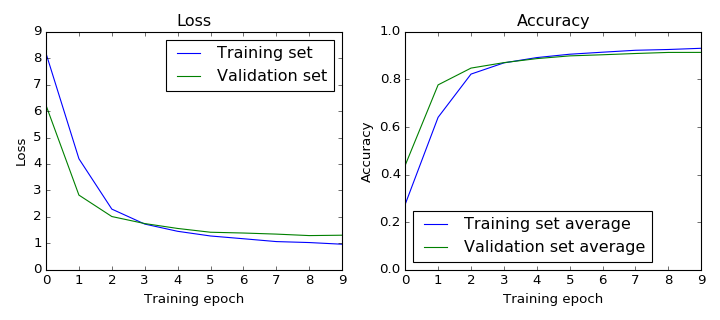

<IPython.core.display.Javascript object>


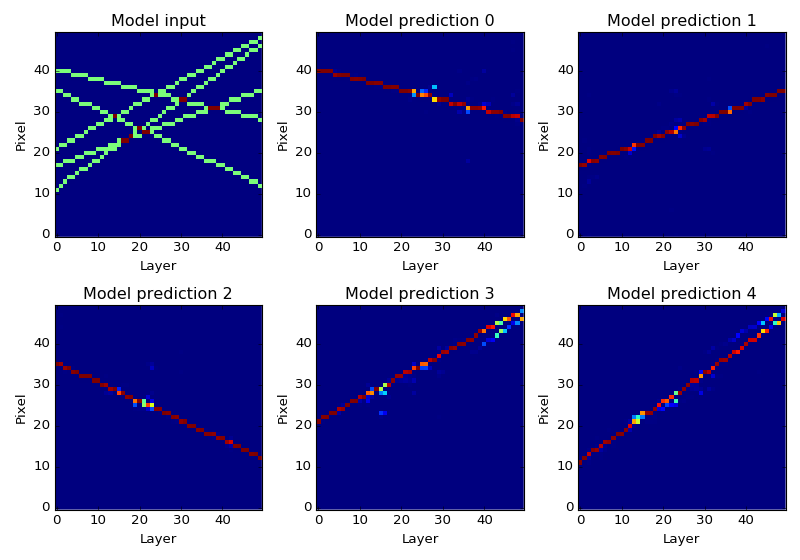

In [15]:
history_report(history3)
fig4 = draw_train_history(history3)
fig5 = draw_outputs(events[ievt], [p[ievt] for p in train3_pred])

Refinement doesn't seem to gain much, if anything. It seems like the model might just get more confused. This was a little surprising to me.